In [ ]:
# -*- coding: utf-8 -*-
"""
Dataset Visualization & Trend Analysis

This script used to conduct an exploratory analysis into the data and visualize trends and patterns such as speaker profiling,
toxicity distribution in dataset etc. The insights drawn from this work will further be used to improve the model performance such as
determining maximum length of tokenized inputs and visualizing the predicted progression in toxicity scores with every
turn in conversation.

Author: Suvro Mukherjee
"""

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
from transformers import AutoTokenizer
from wordcloud import WordCloud
import seaborn as sns

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# ================
# Data Preparation
# ================
# Load dataset
talk_df = pd.read_csv('compiled_data.csv')

talk_df['datetime'] = pd.to_datetime(talk_df['timestamp'], unit='s')
talk_df['hour'] = talk_df['datetime'].dt.hour
talk_df['day'] = talk_df['datetime'].dt.dayofweek

# Define time of day categories
time_bins = [0, 6, 12, 18, 24]
time_labels = ['Night', 'Morning', 'Afternoon', 'Evening']
talk_df['time_of_day'] = pd.cut(talk_df['hour'], bins=time_bins, labels=time_labels, right=False)


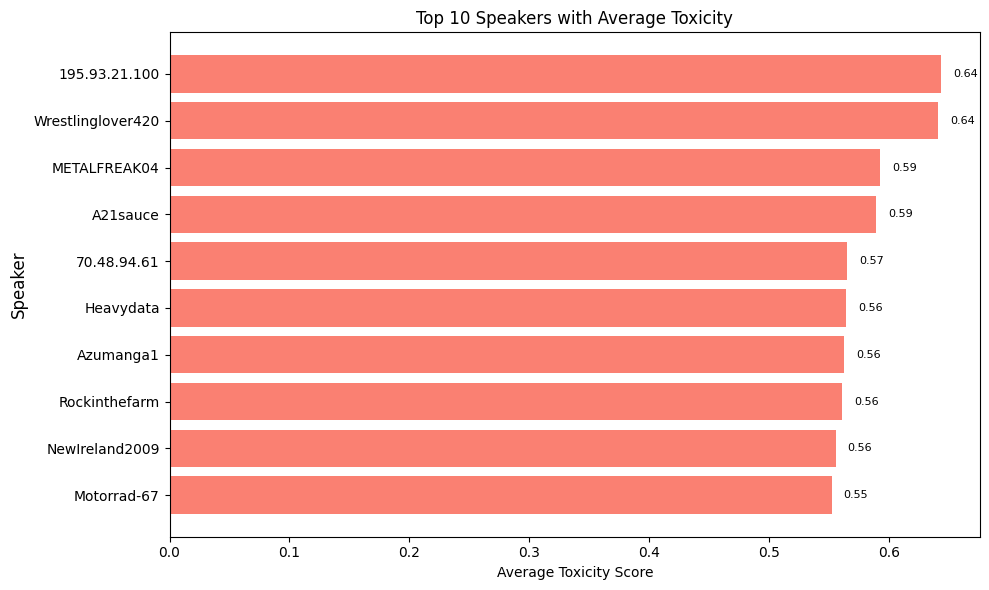

In [ ]:
# Group by speaker to calculate average toxicity
speaker_avg_toxicity = talk_df.groupby('speaker')['Toxicity'].mean()
top_speakers = speaker_avg_toxicity.sort_values(ascending=False).head(10)

# Plot top 10 speakers by average toxicity
plt.figure(figsize=(10, 6))
bars = plt.barh(top_speakers.index, top_speakers.values, color='salmon')
plt.gca().invert_yaxis()
plt.title('Top 10 Speakers with Average Toxicity', fontsize=12)
plt.xlabel('Average Toxicity Score', fontsize=10)
plt.ylabel('Speaker', fontsize=12)
for bar in bars:
    plt.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2,
             f'{bar.get_width():.2f}', va='center', ha='left', fontsize=8)
plt.tight_layout()
plt.show()

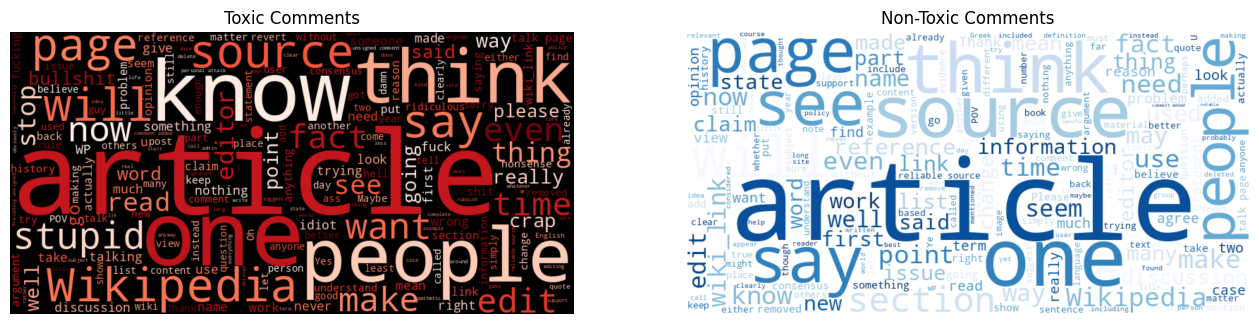

In [ ]:
# Separate toxic and non-toxic comments for word cloud generation
toxic_comments = " ".join(talk_df[talk_df['Comment Nature'] == 'Personal Attack']['text'].astype(str))
non_toxic_comments = " ".join(talk_df[talk_df['Comment Nature'] == 'Normal']['text'].astype(str))

# Generate word clouds
toxic_wc = WordCloud(width=800, height=400, background_color='black', colormap='Reds').generate(toxic_comments)
non_toxic_wc = WordCloud(width=800, height=400, background_color='white', colormap='Blues').generate(non_toxic_comments)

# Plot word clouds
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.imshow(toxic_wc, interpolation='bilinear')
plt.axis('off')
plt.title('Toxic Comments')
plt.subplot(1, 2, 2)
plt.imshow(non_toxic_wc, interpolation='bilinear')
plt.axis('off')
plt.title('Non-Toxic Comments')
plt.show()


<Axes: xlabel='Comment Nature', ylabel='Toxicity'>

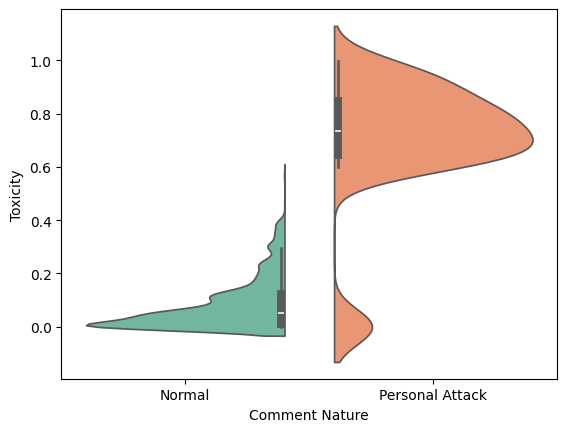

In [ ]:
# Violin plot for toxicity distribution by comment nature
sns.violinplot(data=talk_df, x='Comment Nature', y='Toxicity', palette='Set2', split=True)

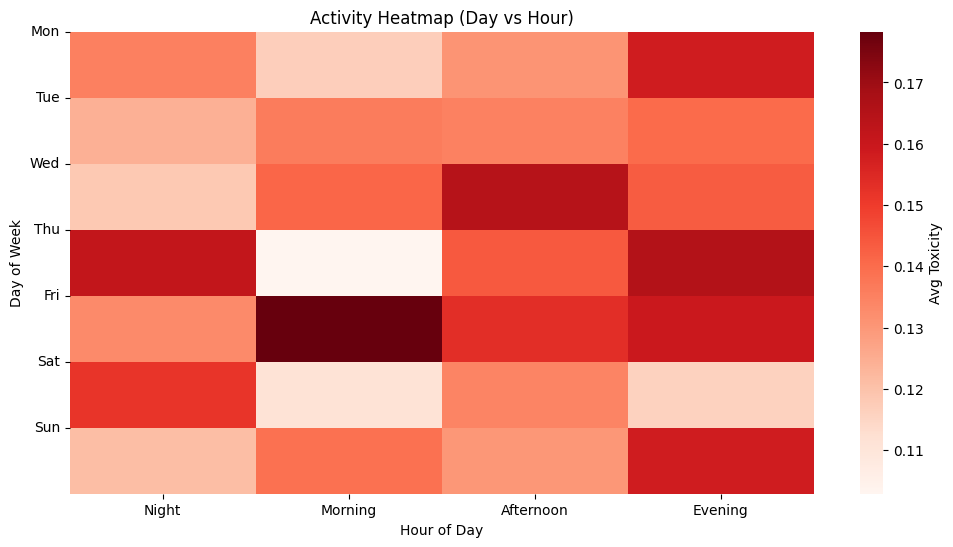

In [ ]:
# Create heatmap to track activity across day and hour
heatmap_data = talk_df.pivot_table(index='day', columns='time_of_day', values='Toxicity', aggfunc='mean')
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, cmap='Reds', annot=False, cbar_kws={'label': 'Avg Toxicity'})
plt.title('Activity Heatmap (Day vs Hour)')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.yticks(ticks=[0, 1, 2, 3, 4, 5, 6], labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], rotation=0)
plt.show()

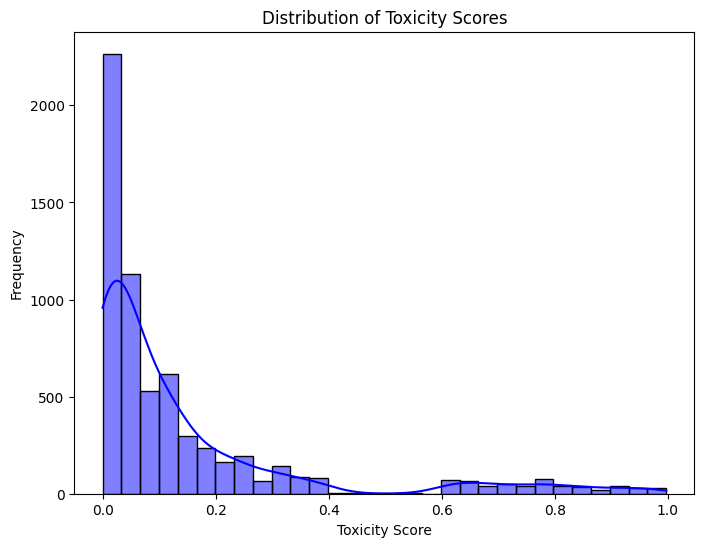

In [ ]:
# Histogram for toxicity score distribution
plt.figure(figsize=(8, 6))
sns.histplot(talk_df['Toxicity'], kde=True, color='blue', bins=30)
plt.title('Distribution of Toxicity Scores')
plt.xlabel('Toxicity Score')
plt.ylabel('Frequency')
plt.show()

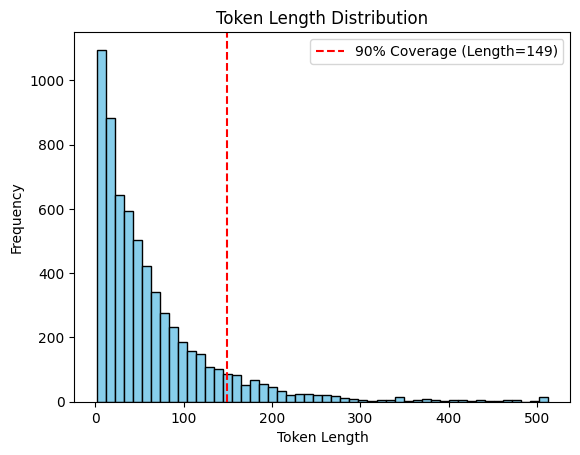

In [ ]:
# Initialize tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Get token lengths, capping at 512
tokenized_lengths = [min(len(tokenizer.encode(text, truncation=False)), 512) for text in talk_df['text']]

# Sort and find the 90% cutoff
sorted_lengths = np.sort(tokenized_lengths)
percentile = 87.5
cutoff_index = int(len(sorted_lengths) * (percentile / 100))
cutoff_length = sorted_lengths[cutoff_index]

# Plot the histogram
plt.hist(tokenized_lengths, bins=50, color='skyblue', edgecolor='black')
plt.axvline(cutoff_length, color='red', linestyle='--', label=f'{percentile}% Coverage (Length={cutoff_length})')
plt.xlabel('Token Length')
plt.ylabel('Frequency')
plt.title('Token Length Distribution')
plt.legend()
plt.show()

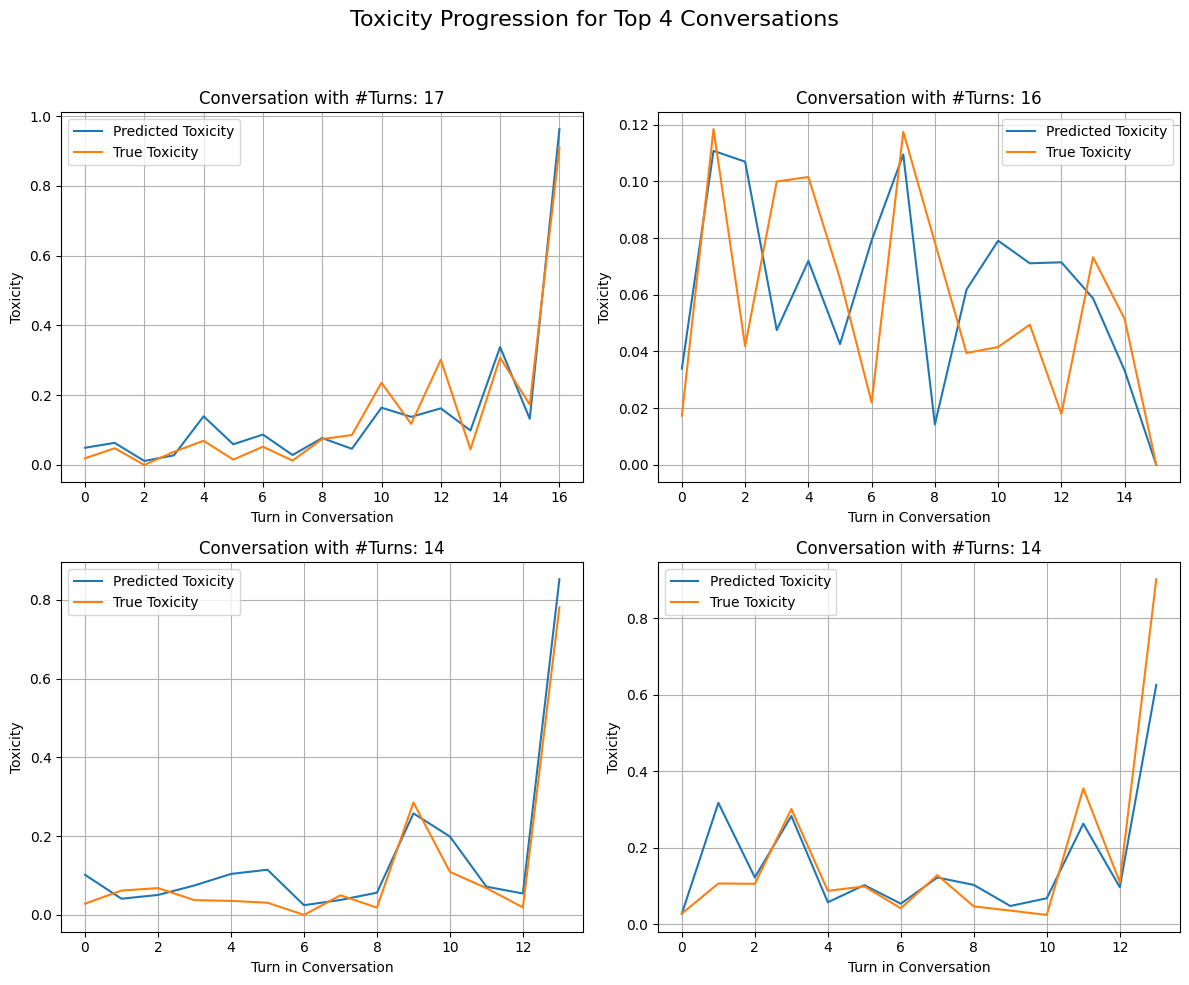

In [ ]:
# Visualize the predicted toxicity progression for the top 4 engaging conversations in test data
highest_comments = test_df['conversation_id'].value_counts().nlargest(4).index

# Set up the plot
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Toxicity Progression for Top 4 Conversations', fontsize=16)

# Flatten the axes for easy iteration
axes = axes.flatten()

# Iterate through the top 4 conversation IDs and plot
for idx, conversation_id in enumerate(highest_comments):
    # Filter the conversation's DataFrame
    conversation_df = test_df[test_df['conversation_id'] == conversation_id]

    # Tokenize data and prepare DataLoader
    # conversation_tokens = tokenize_data(conversation_df, tokenizer)
    conversation_dataset = prepare_data(conversation_df, tokenizer, comment_nature_columns)
    conversation_loader = DataLoader(conversation_dataset, batch_size=1)

    # Generate predictions for toxicity
    predictions = []
    model.eval()
    with torch.no_grad():
        for batch in conversation_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            comment_nature_features = batch['comment_nature_features'].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, comment_nature_features=comment_nature_features)
            predictions.extend(outputs.squeeze(-1).cpu().numpy())

    # Plot the toxicity progression
    axes[idx].plot(range(len(predictions)), predictions, label='Predicted Toxicity')
    axes[idx].plot(range(len(conversation_df)), conversation_df['Toxicity'], label='True Toxicity')
    axes[idx].set_title(f'Conversation with #Turns: {len(conversation_df)}')
    axes[idx].set_xlabel('Turn in Conversation')
    axes[idx].set_ylabel('Toxicity')
    axes[idx].legend()
    axes[idx].grid(True)

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the main title
plt.show()